In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install transformers datasets accelerate nvidia-ml-py3 -q
!!pip install datasets==2.15 -q



["\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'cudf 23.8.0 requires cubinlinker, which is not installed.',
 'cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.',
 'cudf 23.8.0 requires ptxcompiler, which is not installed.',
 'cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.',
 'dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.',
 'apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.',
 'apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.',
 'apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.',
 'cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.4.0 which is incompatible.',
 'cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you

In [4]:
#import setting
import numpy as np
from datasets import Dataset
from pynvml import *
import torch
#from monkeypatch import MonkeyPatch


In [5]:
print(np.__version__)

1.26.4


In [6]:
seq_len, dataset_size = 512, 512
dummy_data = {
    "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(0, 1, (dataset_size)),
}
dset = Dataset.from_dict(dummy_data)
dset.set_format('pt')

In [7]:
dset

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 512
})

In [8]:

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [9]:
print_gpu_utilization()

GPU memory occupied: 107 MB.


In [10]:
#Load Model
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel
model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased").to("cuda")
#model = BertModel.from_pretrained("bert-base-multilingual-cased")
#model.to('cuda')
print_gpu_utilization()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU memory occupied: 1653 MB.


In [11]:
!nvidia-smi

Thu Apr  4 13:24:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              32W / 250W |   1546MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [13]:
#vanilla Traning
from transformers import TrainingArguments, Trainer, logging
logging.set_verbosity_error()

2024-04-04 13:25:11.007605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 13:25:11.007707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 13:25:11.218009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
training_args = TrainingArguments(per_device_train_batch_size=4, **default_args)
trainer = Trainer(model=model, args=training_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'train_runtime': 100.2301, 'train_samples_per_second': 5.108, 'train_steps_per_second': 1.277, 'train_loss': 0.012160632759332657, 'epoch': 1.0}
Time: 100.23
Samples/second: 5.11
GPU memory occupied: 11611 MB.


In [16]:
#Gradient Accumulation
train_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    **default_args
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

{'train_runtime': 110.493, 'train_samples_per_second': 4.634, 'train_steps_per_second': 1.158, 'train_loss': 0.00033337686909362674, 'epoch': 1.0}
Time: 110.49
Samples/second: 4.63
GPU memory occupied: 7239 MB.


In [17]:
#Gradient Checkpointing
train_args = TrainingArguments(
    per_device_train_batch_size=1, 
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True, 
    **default_args
)

trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'train_runtime': 144.6984, 'train_samples_per_second': 3.538, 'train_steps_per_second': 0.885, 'train_loss': 1.862644971595273e-08, 'epoch': 1.0}
Time: 144.70
Samples/second: 3.54
GPU memory occupied: 6859 MB.


In [18]:
#FP16 Training
#default는 32bit 형식 
train_args = TrainingArguments(
    per_device_train_batch_size=4,
    fp16=True, 
    **default_args
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

{'train_runtime': 134.3408, 'train_samples_per_second': 3.811, 'train_steps_per_second': 0.953, 'train_loss': 0.0, 'epoch': 1.0}
Time: 134.34
Samples/second: 3.81
GPU memory occupied: 6853 MB.


In [19]:
#FP16, Grad_acc, Grad_check
train_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True, 
    fp16=True, 
    **default_args
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

{'train_runtime': 159.154, 'train_samples_per_second': 3.217, 'train_steps_per_second': 0.804, 'train_loss': 0.0, 'epoch': 1.0}
Time: 159.15
Samples/second: 3.22
GPU memory occupied: 6883 MB.


Optimizer

In [21]:
#Adafactor
train_args = TrainingArguments(
    per_device_train_batch_size=4,
    optim="adafactor",
    **default_args
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

{'train_runtime': 142.3659, 'train_samples_per_second': 3.596, 'train_steps_per_second': 0.899, 'train_loss': 1.30385160446167e-08, 'epoch': 1.0}
Time: 142.37
Samples/second: 3.60
GPU memory occupied: 3665 MB.


In [22]:
#Adafactor acc, check, fp16
train_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    optim="adafactor",
    **default_args,
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

{'train_runtime': 166.9487, 'train_samples_per_second': 3.067, 'train_steps_per_second': 0.767, 'train_loss': 0.0, 'epoch': 1.0}
Time: 166.95
Samples/second: 3.07
GPU memory occupied: 3921 MB.


In [24]:
!pip install bitsandbytes -q

In [25]:
#8-bit-Adam
import bitsandbytes as bnb
from torch import nn
from transformers.trainer_pt_utils import get_parameter_names

training_args = TrainingArguments(per_device_train_batch_size=4, **default_args)

decay_parameters = get_parameter_names(model, [nn.LayerNorm])
decay_parameters = [name for name in decay_parameters if "bias" not in name]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if n in decay_parameters],
        "weight_decay": training_args.weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
        "weight_decay": 0.0,
    },
]

optimizer_kwargs = {
    "betas": (training_args.adam_beta1, training_args.adam_beta2),
    "eps": training_args.adam_epsilon,
}
optimizer_kwargs["lr"] = training_args.learning_rate
adam_bnb_optim = bnb.optim.Adam8bit(
    optimizer_grouped_parameters,
    betas=(training_args.adam_beta1, training_args.adam_beta2),
    eps=training_args.adam_epsilon,
    lr=training_args.learning_rate,
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset, optimizers=(adam_bnb_optim, None))
result = trainer.train()
print_summary(result)

{'train_runtime': 160.5438, 'train_samples_per_second': 3.189, 'train_steps_per_second': 0.797, 'train_loss': 0.0, 'epoch': 1.0}
Time: 160.54
Samples/second: 3.19
GPU memory occupied: 4437 MB.


In [27]:
trainer = Trainer(model=model, args=training_args, train_dataset=dset, optimizers=(adam_bnb_optim, None))
result = trainer.train()
print_summary(result)

{'train_runtime': 135.6216, 'train_samples_per_second': 3.775, 'train_steps_per_second': 0.944, 'train_loss': 0.0, 'epoch': 1.0}
Time: 135.62
Samples/second: 3.77
GPU memory occupied: 4259 MB.


In [28]:
train_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)
trainer = Trainer(model=model, args = train_args, train_dataset=dset)
result = trainer.train()
print_summary(result)

{'train_runtime': 159.1614, 'train_samples_per_second': 3.217, 'train_steps_per_second': 0.804, 'train_loss': 0.0, 'epoch': 1.0}
Time: 159.16
Samples/second: 3.22
GPU memory occupied: 7527 MB.


In [32]:
case = ['model', 'training', 'grad_acc', 'grad_ckpt', 'fp16', 'adafactor', '8-bit-optim']
gpu_usage = [1653, 11611, 7239, 6859, 6853, 3665, 4259]
time = [0, 100.23, 110.49, 144.70, 134.34, 142.37, 159.16]


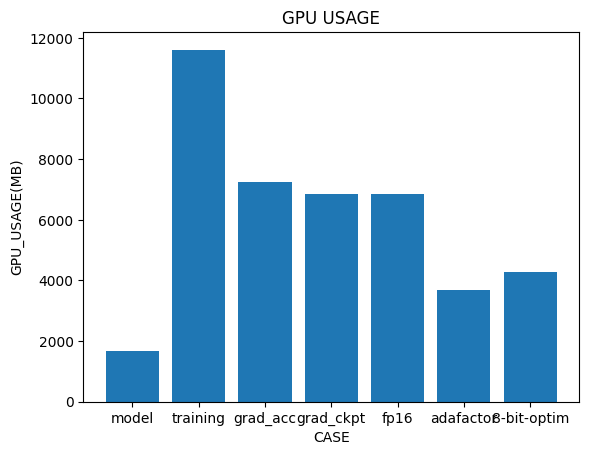

In [35]:
import matplotlib.pyplot as plt
plt.bar(case, gpu_usage)
plt.xlabel("CASE")
plt.ylabel("GPU_USAGE(MB)")
plt.title("GPU USAGE")
plt.show()

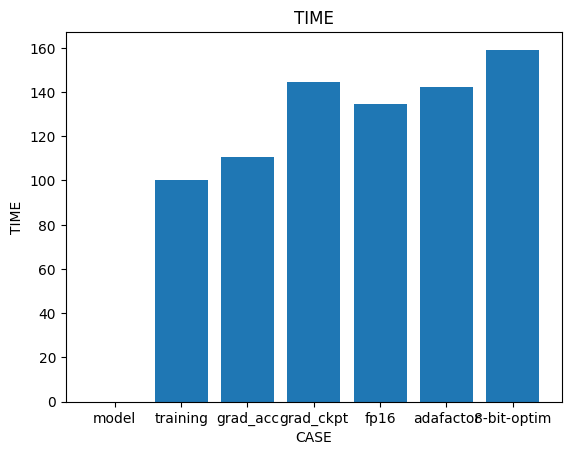

In [37]:
plt.bar(case, time)
plt.xlabel("CASE")
plt.ylabel("TIME")
plt.title("TIME")
plt.show()